# Group member:
1. Ang Jian En Benny
2. Vuong Phuc Lien Hang
3. Yin Shanshan


# Course Project: An Arbitrage-Free Smile Interpolator
*Project report should be submitted as a Jupyter notebook (.ipynb). Each project group should have 1 to 3 members. The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator
  - Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align*}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align*}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}  \tag{2}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align*}
C(K) = E[\max(S-K, 0)]
\end{align*}

And expectation is an integral over the probability density function $p(s)$

\begin{align*}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align*}

The 1st non-arbitrage condition translates to

\begin{align*}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align*}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align*}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align*}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

\begin{align*}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
\end{align*}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. In our case, $M=5$.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- We use $N = 50$ sample points, ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

\begin{align*}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
\end{align*}

   The cubic spline constraints translate to the linear system

\begin{align*} 
\underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
\end{align*}

   If we define
\begin{align*}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
\end{align*}

   we can represent the constraint as:
\begin{align*}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
\end{align*}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
\begin{align*}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}   ~~~\textbf{--- Constraint 2}
\end{align*}

   where

\begin{align*}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
\end{align*}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

\begin{align*}
    p_i > 0 ~~~\textbf{--- Constraint 3}
\end{align*}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

\begin{align*}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
\end{align*}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align*}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align*}

 - Call prices are monotonically decreasing:

    \begin{align*}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align*}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align*}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align*}

    Using $\vec{x}$ as variable and define

    \begin{align*}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align*}

    the problem becomes minimizing

    \begin{align*}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align*}

**Problem Formulation**

We can formulate our problem as
\begin{align*}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
\end{align*}
 subject to constraints 1 to 5.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://buildmedia.readthedocs.org/media/pdf/cvxopt/dev/cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

In [2]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
Sample_points = 50
Range_of_Standard_Deviation = 5

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

In [5]:
import math
from enum import Enum
from scipy import optimize
import bisect
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html
from scipy.interpolate import CubicSpline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [6]:
class PayoffType(Enum):
    Call = 0
    Put = 1

# Calculates the cumulative distribution function (CDF) of the standard normal distribution at a given value x.
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

In [7]:
# The function evaluates and plots the error of the finite difference approximation as the step size h decreases.

def testfinDiff():
    # Defines x0 as the point at which the derivative of the exponential function will be approximated.
    x0 = 0.1
    # Calculates the exact derivative of ex at x0 (which is ex0), and stores it in deriv.
    deriv = math.exp(x0)
    # Sets the initial step size h to 1.
    # Defines n, the number of iterations, as 60 (the number of halving steps for h).
    h = 1
    n = 60
    # Creates a list hs of length n, initially filled with the value h. This will store the step sizes at each iteration.
    hs = [h] * n
    # Creates a list err of length n, initialized to 0. This will store the errors for each step size.
    err = [0] * n
    # Begins a loop over n iterations to compute the finite difference approximation and the corresponding error.
    for i in range(0, n):
        # Approximates the derivative using the finite difference formula
        finDiff = (math.exp(x0+h) - math.exp(x0)) / h
        # Records the current value of h in the hs list at index i.
        hs[i] = h
        # Halve Step Size
        h = h/2
        #print(h)
        # Calculates the absolute error between the finite difference approximation (finDiff) and the exact derivative (deriv).
        err[i] = abs(finDiff - deriv)
        #print(err[i])
        
    # Find the step size with the lowest error
    min_error_index = err.index(min(err))
    best_h = hs[min_error_index]
    
    print(f"The best step size h is {best_h}")
    
    # Plots err (error values) against hs (step sizes) on a graph.
    plt.plot(hs, err, label="error")
    # Configures both the x-axis (step sizes) and y-axis (errors) to use a logarithmic scale.
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

The best step size h is 1.4901161193847656e-08


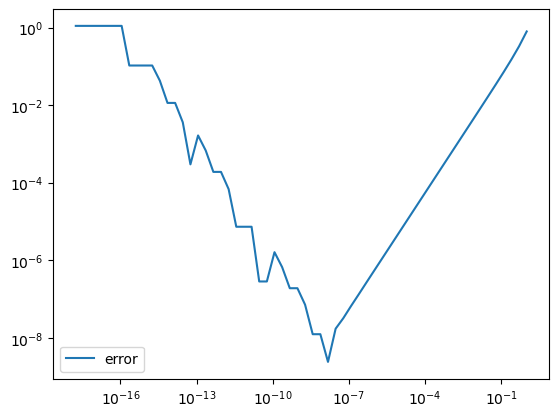

In [8]:
testfinDiff()

In [9]:
# Calculates the forward delta of a European option using the Black-Scholes model.
def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return - cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

In [10]:
# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(S, 
                    r, 
                    q, 
                    T, 
                    vol, 
                    delta, 
                    payoffType):
    
    '''
    S: Spot price of the underlying asset.
    r: Risk-free interest rate.
    q: Dividend yield.
    T: Time to expiration (in years).
    vol: Volatility of the underlying asset.
    delta: The desired delta (i.e., how much the option price changes with the underlying asset's movement).
    payoffType: The option type, either Call or Put.
    '''
    
    # Calculates the forward price of the underlying asset
    fwd = S * math.exp((r-q) * T)
    
    # If the option is a Put, the function ensures that delta is negative (since put deltas are negative).
    if payoffType == PayoffType.Put:
        delta = -delta
    
    # The function defines f(K) as the difference between the calculated delta (fwdDelta(...)) and the given delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    
    a, b = 0.0001, 10000                    # Check if these are ideal
    
    # The function solves for K using Brent’s root-finding method
    return optimize.brentq(f, a, b)

In [11]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        
        '''
        ts: A list of times to expiry (tenors).
        smiles: A list of volatility smile objects, one for each expiry in ts.
        Each smiles[i] should have a method .Vol(k), which returns the implied volatility for a given strike k.
        '''
        self.ts = ts
        self.smiles = smiles
        
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # Determine where t falls within self.ts
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        
        #  If t is before the first expiry → use the first smile.
        # if t is on or in front of first pillar,
        if pos == 0:
            #print(f"Warning: Time to maturity of option is too short, implied vol could be inaccurate")
            return self.smiles[0].Vol(k)
        
        # If t is after the last expiry → use the last smile.
        if pos >= len(self.ts):
            #print(f"Warning: Time to maturity of option is too long, implied vol could be inaccurate")
            return self.smiles[-1].Vol(k)
        
        # If t is between two expiries, interpolate using variance-based linear interpolation
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return

    # This is Lesson 5 Slide 20
    # Computes the first derivative of volatility w.r.t. strike k (Numerical Approximation)
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002                                # Check if these are ideal
    
    # Computes the first derivative of volatility w.r.t. time to expiry t
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005                                      # Check if these are ideal
    
    # Computes the second derivative of volatility w.r.t. strike k (Convexity of Smile)
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001          # Check if these are ideal

Local volatility is a model where the volatility of an asset depends on both time t and asset price S. It extends the Black-Scholes model by allowing for a volatility surface rather than a constant volatility.

In [13]:
# This is Lesson 5 Slide 21
# This LocalVol class computes the local volatility surface from an implied volatility surface using Dupire's equation.
class LocalVol:
    def __init__(self, iv, S0, rd, rf):
        
        '''
        iv: An implied volatility surface (an instance of ImpliedVol).
        S0: The current spot price of the underlying asset.
        rd: The domestic interest rate (risk-free rate).
        rf: The foreign interest rate (used in FX options, otherwise set to 0).
        '''
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
        
    # This function transforms implied volatility into local volatility.
    # This is Lesson 5 Slide 19  
    def LV(self, t, s):
        # If t is extremely small (<1e−6), return the implied volatility as a fallback.
        if t < 1e-6:
            return self.iv.Vol(t, s)
        
        # Extract implied volatility and its derivatives
        imp = self.iv.Vol(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        
        # Compute d1 (Black-Scholes-like term)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        
        # Dupire's equation for local variance
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        
        # Ensure variance stays within reasonable bounds
        localvar = min(max(numerator / denominator, 1e-8), 1.0) # Safeguard procedure               # Check if these are ideal
        
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)

In [14]:
class EuropeanOption():
    
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
        
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
        
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [15]:
# Black-Scholes analytic pricer
def bsPrice(S, 
            r, 
            q, 
            vol, 
            T, 
            strike, 
            payoffType):
    
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    
    else:
        raise Exception("not supported payoff type", payoffType)

In [16]:
# PDE pricer with local volatility
# This function numerically solves the Black-Scholes PDE with local volatility
def pdePricerX(S0, 
               r, 
               q, 
               lv, 
               NX, 
               NT, 
               w, 
               trade):
    
    '''
    S0: Initial stock price.
    r: Risk-free interest rate.
    q: Dividend yield.
    lv: Local volatility model (an instance of LocalVol).
    NX: Number of space steps (controls accuracy in the asset price dimension).
    NT: Number of time steps (controls accuracy in the time dimension).
    w: Weighting factor for time stepping scheme:
        w=0 → Explicit scheme (unstable for large steps).
        w=1 → Implicit scheme (stable but computationally expensive).
        w=0.5 → Crank-Nicolson scheme (best balance between stability and efficiency).
    trade: An object containing:
        trade.expiry: Expiration time T.
        trade.payoff(S): Payoff function, e.g., max(S−K,0) for a call.
    '''
    
    # set up pde grid
    mu = r - q
    T = trade.expiry
    
    # The algorithm works on a log-space grid (i.e., we solve for X=lnS instead of S)
    # The log transformation helps reduce numerical errors for high volatility assets.
    # The spatial range is set to x standard deviations from the initial stock price.
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = Range_of_Standard_Deviation * vol0 * math.sqrt(T)                    # Determines range based on volatility
    maxX = X0 + (mu - vol0 * vol0 * 0.5)*T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    
    # set up spot grid
    # This is a log-price grid (each point represents a price level in log space).
    xGrid = np.array([minX + i*dx for i in range(NX)])
    
    # Initialize the payoff
    # The option payoff is computed at expiry for all grid points.
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    
    # Backward induction
    # This loop iterates backward in time, evolving the option price towards today
    for j in range(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))           # Local volatility at time j*dt and spot exp(xGrid[i])
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
            
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        
        # Time Stepping Scheme
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        # Solving for ps (option price at the next time step)
        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    
    # The final option price at S0 is obtained via linear interpolation.
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

In [18]:
# Needs strikes (ks), vols [p10, p25, atmvol, c25, c10], and time
class SmileAF:
    def __init__(self, strikes, vols, T):
        self.atmvol = vols[int(len(vols)/2)]        # Get the at the money volatility as the middle of the volatilities provided
        self.fwd = strikes[int(len(strikes)/2)]     # Get the forward price as the middle of the strikes provided
        self.T = T
        self.N = Sample_points
        
        # Calculate minimum strike and maximum strike based on x standard deviations away from forward price
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5*stdev*stdev-Range_of_Standard_Deviation * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev+Range_of_Standard_Deviation * stdev)
        
        # Sets up an evenly spaced strike grid between kmin and kmax
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        # now we need to construct our constrained optimization problem to solve for cs (call prices) and ps (probability density functions)
        # ... YOUR CODE HERE ... to solve for self.cs and self.ps
        
        # Constraint 1: Second-Order Derivative (Convexity Condition)
        '''
        Constraint 1 enforces the convexity condition on the call price function by ensuring that its 
        second-order derivative is well-behaved. Specifically, this is important because the second derivative 
        of the call price function with respect to strike price corresponds to the risk-neutral probability 
        density function (pdf) of the underlying asset price. This constraint ensures that the implied volatility 
        surface is arbitrage-free by maintaining a well-behaved, convex call price function.
        Without this, the second derivative (risk-neutral density) could be negative or erratic, 
        leading to violations of no-arbitrage conditions.
        '''
        # Q is a (Sample_points-2) × Sample_points matrix that applies finite-difference approximations for the second derivative of the call prices.
        Q = np.zeros((self.N-2, self.N))            #Sample_points-2 x Sample_points
        
        # R is a (N-2) × (N-2) matrix that helps maintain smoothness by enforcing constraints on the second derivative continuity.
        R = np.zeros((self.N-2, self.N-2))          #Sample_points-2 x Sample_points-2
        
        # Setting cublic spline constraint for Q
        for i in range(self.N-2):       # Need N-2 to avoid out of range
            Q[i][i] = 1
            Q[i][i+1] = -2
            Q[i][i+2] = 1

            # Setting cubic spline constaint for R to enforce second derivative smoothness.
            if i == 0:                  # For first row
                R[i][i] = 2/3
                R[i][i+1] = 1/6
            elif i == self.N-3:         # For last row
                R[i][-1] = 2/3
                R[i][-2] = 1/6
            else:                       # For all the rows in between
                R[i][i-1] = 1/6
                R[i][i] = 2/3
                R[i][i+1] = 1/6

        '''
        The R Matrix for Smoothness
        The matrix R is built using coefficients that represent a cubic spline penalty term, ensuring that the second derivative does not change too abruptly.
        It is scaled by u^2, where u is the spacing between strikes.
        The structure of R ensures a smooth transition in convexity across different strike levels.
        '''
        R = R * u**2
        
        negativeR = R * -1
        
        # The final constraint matrix Constraint_1_LHS is formed by concatenating Q and -R.
        Constraint_1_LHS = np.concatenate((Q, negativeR), axis=1)
        
        # Constraint_1_RHS is set to zero because we are enforcing an equality constraint on the second derivative values (i.e., no extra bias or deviation).
        Constraint_1_RHS =np.zeros((self.N-2,1))
        
        '''
        Constraint 2 ensures that the call prices at specific market strikes match the corresponding 
        Black-Scholes prices implied by the given input volatilities. This is crucial for ensuring that 
        the resulting arbitrage-free volatility surface is consistent with observed market data. 
        Constrains call prices at five key strikes (P10, P25, ATM, C25, C10) to match market Black-Scholes prices.
        Uses cubic spline interpolation to smoothly adjust call prices at these strikes.
        Ensures no arbitrage by making sure that implied call prices are consistent with observed data.
        '''
        
        # Constraint 2
        # Constraint_2_LHS: A 5×(2N−2) matrix that will enforce five constraints on call prices.
        Constraint_2_LHS = np.zeros((5,2*self.N-2))
        
        # Constraint_2_RHS: A 5×1 vector that stores the target call prices from Black-Scholes.
        Constraint_2_RHS =np.zeros((5,1))
        
        # For each of the 5 key strikes, the constraint will ensure that the computed call prices 
        # from the arbitrage-free model match the Black-Scholes prices.
        for i in range(5):
            payoffType = PayoffType.Call
            k = strikes[i]
            vol = vols[i]
            
            # The function bisect.bisect_left(self.ks, k) finds the closest right-side index 
            # in self.ks (the model's strike grid) that is greater than or equal to the given market strike k.
            # firstTempPosC and secondTempPosC identify the two closest call price positions.
            secondTempPosC = bisect.bisect_left(self.ks, k)
            firstTempPosC = secondTempPosC - 1
            
            # firstTempPosP and secondTempPosP map these to the corresponding probability density function (PDF) positions (which are offset by Sample_points-1 in the matrix).
            firstTempPosP = firstTempPosC + Sample_points-1
            secondTempPosP = secondTempPosC + Sample_points-1

            # This computes the Black-Scholes undiscounted call price for the given strikek, time-to-maturity T, and market-implied volatility σ.
            # calculation of C(kj) using black scholes
            # tempPrice = bsPrice (self.S, self.r, self.q, vol, T, k, payoffType)
            tempStdDev = vol * np.sqrt(T)
            d1 = math.log(self.fwd / k) / tempStdDev + tempStdDev / 2
            d2 = d1 - tempStdDev
            tempPrice = (self.fwd * cnorm(d1) - cnorm(d2) * k)
            
            # This defines cubic spline interpolation weights that will allow us to reconstruct C(k) using neighboring grid points.
            a = (self.ks[secondTempPosC] - k) / self.u
            b = 1 -a 
            c = (a * a * a - a) * self.u * self.u / 6.0
            d = (b * b * b - b) * self.u * self.u / 6.0


            # Setting invididual constraint
            # The weights for the cubic spline interpolation are placed in the c2 matrix.
            Constraint_2_LHS[i][firstTempPosC] = a
            Constraint_2_LHS[i][secondTempPosC] = b
            Constraint_2_LHS[i][firstTempPosP] = c
            Constraint_2_LHS[i][secondTempPosP] = d

            # The target Black-Scholes price is placed in the Constraint_2_RHS vector.
            Constraint_2_RHS[i] = tempPrice
        
        '''
        Constraint 3 enforces non-negativity on the probability density function (PDF), 
        ensuring that implied risk-neutral probabilities are non-negative.
        This is crucial for an arbitrage-free volatility surface because a negative 
        probability density would imply violations of no-arbitrage conditions in option pricing. 
        Represents a simple inequality constraint applied to probability density values (ps).
        Does not affect call prices (cs)—it only constrains the densities.
        '''
        
        # Constraint 3
        # Constraint_3_LHS is a (N−2)×(2N−2) matrix.
        # The number of rows (N-2) corresponds to the number of interior points where the probability density must be enforced as non-negative.
        # The number of columns (2N-2) accounts for both call prices (N) and probability densities (N-2).
        Constraint_3_LHS = np.zeros((self.N-2, 2*self.N-2))
        
        # tempCounter = Sample_points refers to the starting index of the probability densities (ps) in the c3 matrix.
        # Since there are Sample_points call prices (cs), the probability densities (ps) start right after them at index N = Sample_points.
        tempCounter = Sample_points
        
        # The loop iterates over N-2 rows (i.e., for all interior probability densities).
        # Each row sets a single entry in c3 to -1 at the corresponding density index.
        # This effectively enforces the constraint:
        # -pi ≤ 0 ∀i
        # which can be rewritten as:
        # pi ≥ 0
        # ensuring non-negativity of all interior probability densities.
        
        for i in range (self.N-2):
            Constraint_3_LHS[i][tempCounter] = -1
            tempCounter += 1
            
        # Constraint_3_RHS is a zero vector of size (N−2)×1, representing the right-hand side (RHS) of the inequality constraint.
        Constraint_3_RHS = np.zeros((self.N-2,1))
        
        '''
        Constraint 4 enforces that the total probability density integrates to 1, ensuring a valid 
        risk-neutral probability distribution.
        This is a fundamental requirement because probability densities must sum to one over all 
        possible future asset prices in a valid financial model. 
        Ensures the implied probability distribution is valid by enforcing that the total probability integrates to 1.
        Uses numerical integration via strike spacing (u) to approximate the probability sum.
        Does not affect call prices (cs), only constrains probability densities (ps).
        '''
        
        # Constraint 4
        # Constraint_4_LHS is a single-row matrix of shape (1,2N−2).
        Constraint_4_LHS = np.zeros((1, 2*self.N-2))
        
        # Iterates over indices corresponding to probability densities (ps).
        # The densities start at index N = Sample_points and go up to 2(Sample_points)-2 = 98.
        # Each probability density is multiplied by u (the spacing between strikes).
        for i in np.arange(self.N, 2*self.N-2):
            Constraint_4_LHS[0][i] = self.u
        # Constraint_4_RHS is a single-element vector with a value of 1, representing the total integrated probability.
        Constraint_4_RHS = np.array([[1]])
      
        '''
        Constraint 5 enforces boundary conditions on call prices (cs).
        It ensures that:
        The call price at the lowest strike (kmin) satisfies the arbitrage-free lower bound.
        The call price at the highest strike (kmax) approaches zero.Prevents arbitrage by ensuring realistic call prices.
        Call price at lowest strike:  C(kmin) = F - kmin
        Call price at highest strike:  C(kmax) = 0
        '''
    
        # Constraint 5
        # Constraint_5_LHS is a 2×(2N−2) matrix, defining two boundary constraints.
        Constraint_5_LHS = np.zeros((2, 2*self.N-2))
        Constraint_5_LHS[0][0] = 1
        Constraint_5_LHS[1][self.N-1] = 1             # This enforces that at the highest strike, the call price should be close to 0.
        
        # Constraint_5_RHS is a 2×1 vector, storing the values that the constraints enforce.
        Constraint_5_RHS = np.zeros((2,1))
        Constraint_5_RHS[0][0] = self.fwd-kmin       # This ensures the deep in-the-money call price is correctly set based on intrinsic value:
        
        '''
        Constraint 6 enforces monotonicity in call prices.
        It ensures that call option prices do not increase as the strike price increases, 
        which is a fundamental no-arbitrage condition.
        '''

        # Constraint 6
        # Constraint_6_LHS is a (N−1)×(2N−2) matrix, setting up N−1 constraints.
        Constraint_6_LHS = np.zeros((self.N-1, 2*self.N-2))
        
        # Constraint_6_RHS is a (N−1)×1 vector, initialized to zero.
        Constraint_6_RHS = np.zeros((self.N-1,1))
        
        # This enforces the condition: C(ki+1) - C(ki) <= 0
        for i in range(self.N-1):
            Constraint_6_LHS[i][i] = -1
            Constraint_6_LHS[i][i+1] = 1
        
        # Setting the Objective Function for Quadratic Programming
        # H is an (2N-2) × (2N-2) matrix, which defines the quadratic objective function in QP.
        H = np.zeros((2*self.N-2, 2*self.N-2))
        
        # The second block (H[self.N:, self.N:] = r) applies the smoothness penalty on the second derivative (convexity).
        # r is a penalty matrix ensuring the second derivative of call prices is smooth.
        H[self.N:, self.N:] = R
        
        # changing to cvxopt format
        # P represents the quadratic term in the QP objective function.
        # https://cvxopt.org/userguide/matrices.html
        # tc stands for type code. The possible values are 'i', 'd', and 'z', for integer, real (double), and complex matrices, respectively.
        P = matrix(2*H, tc='d')
        
        # q is the linear term, set to zero because we're only minimizing the curvature.
        q = matrix(np.zeros((2*self.N-2)), tc='d')
        
        # Setting Up Inequality Constraints (Gx ≤ h)
        # Constraint 3 and 6 are inequality constraints
        # Constraint 3 enforces non-negative densities (no negative probabilities).
        # Constraint 6 enforces monotonicity in call prices (no arbitrage).
        G = matrix(np.concatenate((Constraint_3_LHS, Constraint_6_LHS), axis=0), tc='d')    
        h = matrix(np.concatenate((Constraint_3_RHS, Constraint_6_RHS), axis=0), tc='d')

        # Setting Up Equality Constraints (Ax = b)
        # Constraint 1,2,4 and 5 are equality constraints
        args1 = (Constraint_1_LHS, Constraint_2_LHS, Constraint_4_LHS, Constraint_5_LHS)
        args2 = (Constraint_1_RHS, Constraint_2_RHS, Constraint_4_RHS, Constraint_5_RHS)
        
        A = matrix( np.concatenate(args1), tc='d')
        b = matrix( np.concatenate(args2), tc='d')

        # Solving for Call Prices and Densities
        # https://cvxopt.org/userguide/coneprog.html
        
        # In solver, we minimize 0.5xPx + qx, subject to the constraints that
        # G must be less than equal to h
        # A must be equal to b
        sol = solvers.qp(P,q,G,h,A,b)
        
        # Extracting the Solution
        self.cs = sol['x'][0:self.N] # undiscounted call option prices
        self.ps = self.ps.reshape(Sample_points,1)
        self.ps[1:-1] = sol['x'][self.N:2*self.N-2] # Risk-neutral probability densities
        
        # Print some of the results to confirm that the optimization was dine correctly
        
        # print("============================================================================================================================")
        # print(f"Matrix P")
        # print(P) 
        
        # print("============================================================================================================================")
        # print(f"Matrix q")
        # print(q) 
        
        # print("============================================================================================================================")
        # print(f"Matrix G")
        # print(G) 
        
        # print("============================================================================================================================")
        # print(f"Matrix h")
        # print(h) 
        
        # print("============================================================================================================================")
        # print(f"Matrix A")
        # print(A) 
        
        # print("============================================================================================================================")
        # print(f"Matrix b")
        # print(b) 

        # now we obtained (call prices) cs and (probability density functions) ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.
        
        # This function calculates the difference between the Black-Scholes price and the given market price (prc).
        def implyVol(k, prc, v):
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        
        # khmin and khmax define the range of strikes over which we will compute implied volatilities.
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes)-1])
        
        # kks: Stores strike prices used for cubic spline interpolation.
        kks = [0] * ((khmax+1) - (khmin-1) + 2)
        
        #  Stores the implied volatilities corresponding to those strikes.
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        
        # Compute Implied Volatility for Each Strike
        for i in range(khmin-1, khmax+1):                       # For each strike price self.ks[i] in the range [khmin-1, khmax+1]
            prc = self.Price(self.ks[i])                        # Get the market price
            f = lambda v: implyVol(self.ks[i], prc, v)          # Computes the difference between the Black-Scholes price and prc.
            a, b = 1e-8, 10                                     # The 2 ends of the bracketing interval
            vs[i - (khmin-1) + 1] = optimize.brentq(f, a, b)    # Finds the root (i.e., implied volatility v that makes f(v) = 0).
            kks[i - (khmin-1) + 1] = self.ks[i]                 # Store the results in vs[] (volatility) and kks[] (strike price).
        
        kks[0] = kmin                       # Set the minimum strike (kmin) and its volatility equal to the next value.
        vs[0] = vs[1]
        kks[len(kks)-1] = kmax              # Set the maximum strike (kmax) and its volatility equal to the previous value.
        vs[len(vs)-1] = vs[len(vs)-2]

        # Fit a Cubic Spline to the Implied Volatility Surface
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html
        self.vs = vs
        self.cubicVol = CubicSpline(kks,                            # Strike Price
                                    vs,                             # Volatility
                                    bc_type=((1, 0.0), (1, 0.0)),   # Natural
                                    extrapolate=True)    

    def Vol(self, k):           # scipy cubicspline bc_type confusing, extrapolate by ourselfs
        if k < self.ks[0]:      # If strike lower than lowest strike given
            return self.vs[0]   # Use lowest strike given
        if k > self.ks[-1]:     # If strike higher than highest strike given
            return self.vs[-1]  # Use highest strike given
        else:
            return self.cubicVol(k)

    # This function approximates the price of a European call option for a given strike price k. 
    # It does so using cubic spline interpolation to ensure smoothness.
    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        # If strike price k is smaller than the minimum strike (self.ks[0]), the price is 
        # approximated as a deep in-the-money option:
        if k <= self.ks[0]:
            return self.fwd - k
        # If strike price k is larger than the maximum strike (self.ks[self.N-1]), 
        # the call option is assumed to be deep out-of-the-money, so its price is 0.
        if k >= self.ks[self.N-1]:
            return 0.0
        
        # Uses binary search (bisect_left) to find the smallest index pos where self.ks[pos] >= k.
        pos = bisect.bisect_left(self.ks, k)
        
        # a and b are linear interpolation weights that determine how much weight each neighboring strike contributes.
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        
        # c and d are cubic spline adjustments to ensure smoothness.
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]

In [19]:
# Needs strikes (ks), vols [p10, p25, atmvol, c25, c10]
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]        # Check this part
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, 
                              vols, 
                              bc_type=((1, 0.0), (1, 0.0)),                     # Natural
                              extrapolate=True)   

    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

In [20]:
# Check against assignment 2
def smileFromMarks(T, 
                   S, 
                   r, 
                   q, 
                   atmvol, 
                   bf25, 
                   rr25, 
                   bf10, 
                   rr10, 
                   smileInterpMethod):
    
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2

    ks = [ strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T),
           strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    # print(T, ks)
    
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])
    
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T)

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

In [22]:
def createTestFlatVol(S, 
                      r, 
                      q, 
                      smileInterpMethod):
    
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [smileFromMarks(pillars[i], 
                             S, 
                             r, 
                             q, 
                             atmvols[i], 
                             bf25s[i], 
                             rr25s[i], 
                             bf10s[i], 
                             rr10s[i], 
                             smileInterpMethod) for i in range(len(pillars))]
    
    return ImpliedVol(pillars, smiles)

In [23]:
def createTestImpliedVol(S, 
                         r, 
                         q, 
                         sc, 
                         smileInterpMethod):
    
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    
    smiles = [smileFromMarks(pillars[i], 
                             S, 
                             r, 
                             q, 
                             atmvols[i], 
                             bf25s[i]*sc, 
                             rr25s[i]*sc, 
                             bf10s[i]*sc, 
                             rr10s[i]*sc, 
                             smileInterpMethod) for i in range(len(pillars))]
    
    return ImpliedVol(pillars, smiles)

In [24]:
def plotTestImpliedVolSurface(S, 
                              r, 
                              q, 
                              iv):
    
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)        # 10 Delta Put
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)       # 10 Delta Call
    ks = np.arange(kmin, kmax, 0.01)    # Strikes at every 0.01 interval
    vs = np.ndarray((len(ts), len(ks)))             # Create implied vol grid
    lv = LocalVol(iv, S, r, q)                      # Calculate local vol
    lvs = np.ndarray((len(ts), len(ks)))            # Create local vol grid
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])         # Get implied vol into the grid
            lvs[i, j] = lv.LV(ts[i], ks[j])         # Get local vol into the grid
            
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    
    X, Y = np.meshgrid(ks, ts)      # Create a grid of strikes and time
    
    ha.plot_surface(X, Y, vs)       # Plot implied vol surface
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    
    hb.plot_surface(X, Y, lvs)      # Plot local vol surface
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()

In [25]:
# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, 
                   r, 
                   q, 
                   impliedVol):
    
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]       # Time steps to plot
    ds = np.arange(0.1, 1.0, 0.1)                                       # Deltas to plot
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S = S0, 
                                r = r, 
                                q = 0, 
                                T = T, 
                                vol = impliedVol.Vol(T, S0*math.exp(r*T)), 
                                delta = ds[i], 
                                payoffType = PayoffType.Put)
            
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, 
                         r, 
                         q, 
                         vol,
                         T, 
                         K, 
                         payoff)
            
            # Calculate pde price
            pde = pdePricerX(S0 = S0, 
                             r = r, 
                             q = q, 
                             lv = lv, 
                             NX = max(Sample_points, int(Sample_points * T)), 
                             NT = max(Sample_points, int(Sample_points * T)), 
                             w = 0.5, 
                             trade = trade)
            
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
            
    Errors = np.sum (err) 
    
    print(f"Sum of Errors is {Errors:.2f}" )    
    
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

In [27]:
S = 1.25805     # Spot
r = 0.01        # Interest rate
q = 0.0         # Dividend rate

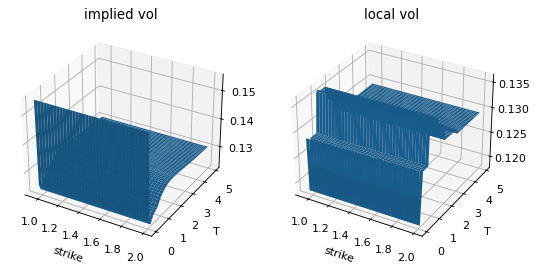

Sum of Errors is 70.88


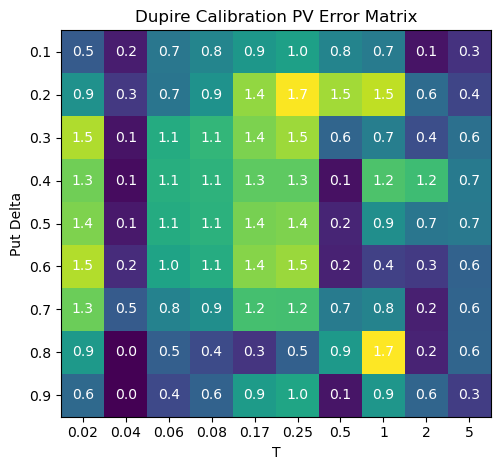

In [28]:
iv = createTestImpliedVol(S, 
                          r, 
                          q, 
                          sc = 0.0,                 # No smile
                          smileInterpMethod='CUBICSPLINE')

plotTestImpliedVolSurface(S, r, q, iv)

pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

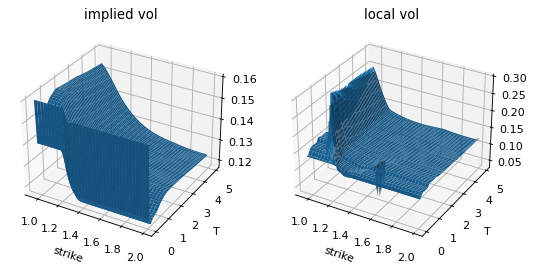

Sum of Errors is 252.74


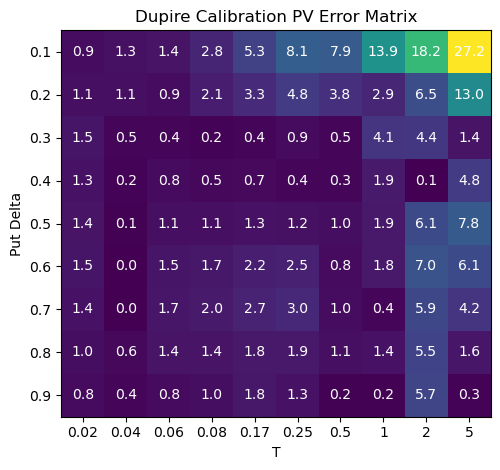

In [30]:
iv = createTestImpliedVol(S, 
                          r, 
                          q, 
                          sc = 0.5,             # Slight smile
                          smileInterpMethod='CUBICSPLINE')

plotTestImpliedVolSurface(S, r, q, iv)

pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

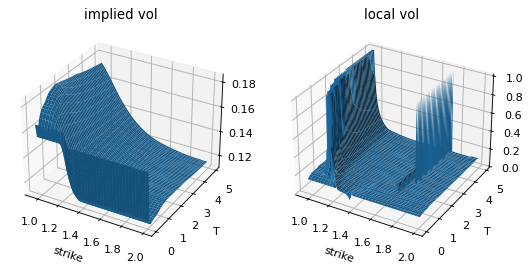

Sum of Errors is 737.68


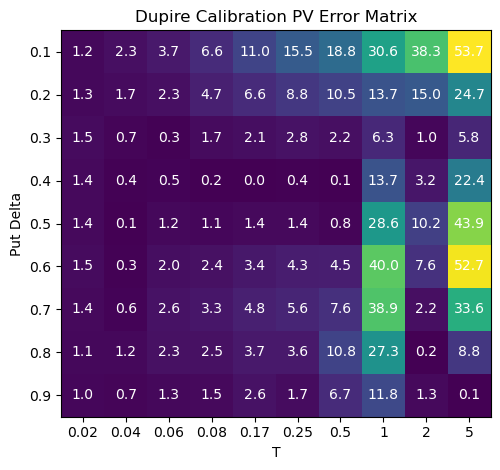

In [32]:
iv = createTestImpliedVol(S, 
                          r, 
                          q, 
                          sc = 1.0,             # Full smile
                          smileInterpMethod='CUBICSPLINE')

plotTestImpliedVolSurface(S, r, q, iv)

pdeCalibReport(S, r, q, iv)

***
### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  5.7198e-02 -1.0808e+03  4e+03  2e+01  1e+02
 1:  5.7906e-02 -1.6949e+02  3e+02  1e+00  7e+00
 2:  5.9554e-02 -2.3830e+01  3e+01  1e-02  7e-02
 3:  5.9566e-02 -5.5094e-01  6e-01  3e-04  1e-03
 4:  5.9524e-02 -1.2177e-01  2e-01  6e-05  3e-04
 5:  5.9077e-02  3.3330e-02  3e-02  8e-06  5e-05
 6:  5.8502e-02  5.4875e-02  4e-03  9e-07  5e-06
 7:  5.8164e-02  5.7556e-02  6e-04  1e-07  6e-07
 8:  5.8034e-02  5.7915e-02  1e-04  1e-08  8e-08
 9:  5.7995e-02  5.7982e-02  1e-05  1e-09  7e-09
10:  5.7989e-02  5.7989e-02  3e-07  2e-11  9e-11
11:  5.7989e-02  5.7989e-02  4e-09  2e-13  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7489e-02 -7.1118e+02  3e+03  2e+01  9e+01
 1:  5.8115e-02 -1.1489e+02  2e+02  1e+00  5e+00
 2:  5.9474e-02 -1.3517e+01  1e+01  1e-02  5e-02
 3:  5.9460e-02 -4.8890e-01  6e-01  4e-04  2e-03
 4:  6.0231e-02 -1.4070e-01  2e-01  7e-05  3e-04
 5:  5.9925e-02  3.6837e-02  2e-02  7e-06  4e-0

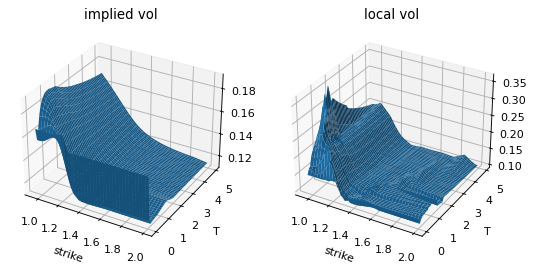

Sum of Errors is 261.08


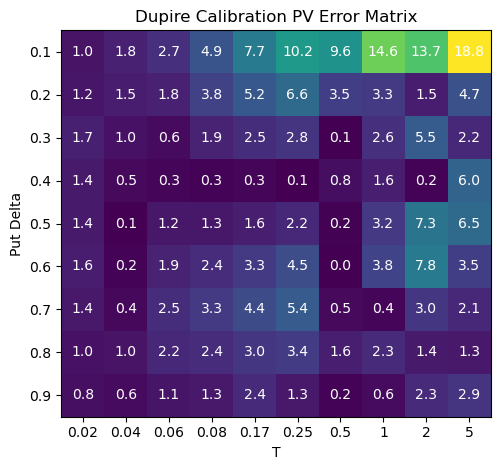

In [34]:
iv = createTestImpliedVol(S, 
                          r, 
                          q, 
                          sc = 1.0,         # Full smile
                          smileInterpMethod='AF')

plotTestImpliedVolSurface(S, r, q, iv)

pdeCalibReport(S, r, q, iv)

### BONUS QUESTION

     pcost       dcost       gap    pres   dres
 0:  5.6202e-02 -9.7036e+02  4e+03  2e+01  1e+02
 1:  5.7223e-02 -1.6525e+02  4e+02  2e+00  9e+00
 2:  6.2885e-02 -4.3236e+01  5e+01  2e-02  1e-01
 3:  6.2915e-02 -7.9988e-01  9e-01  3e-04  1e-03
 4:  6.1324e-02 -1.2645e-01  2e-01  6e-05  3e-04
 5:  5.9540e-02  1.6868e-02  4e-02  4e-06  2e-05
 6:  5.8482e-02  5.0017e-02  8e-03  6e-07  3e-06
 7:  5.7830e-02  5.6099e-02  2e-03  8e-08  4e-07
 8:  5.7555e-02  5.7164e-02  4e-04  1e-08  5e-08
 9:  5.7455e-02  5.7417e-02  4e-05  2e-10  1e-09
10:  5.7444e-02  5.7439e-02  5e-06  2e-11  1e-10
11:  5.7442e-02  5.7442e-02  3e-07  2e-13  8e-13
12:  5.7442e-02  5.7442e-02  2e-08  9e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6277e-02 -6.2499e+02  3e+03  2e+01  9e+01
 1:  5.7216e-02 -1.0776e+02  3e+02  1e+00  6e+00
 2:  6.0307e-02 -2.2455e+01  2e+01  1e-02  6e-02
 3:  6.0320e-02 -4.8212e-01  6e-01  3e-04  1e-03
 4:  5.9854e-02 -6.8720e-02  1e-01  5e-05  2e-0

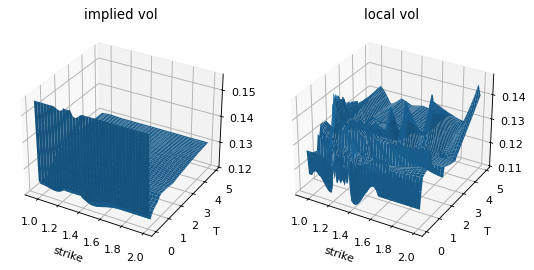

Sum of Errors is 89.51


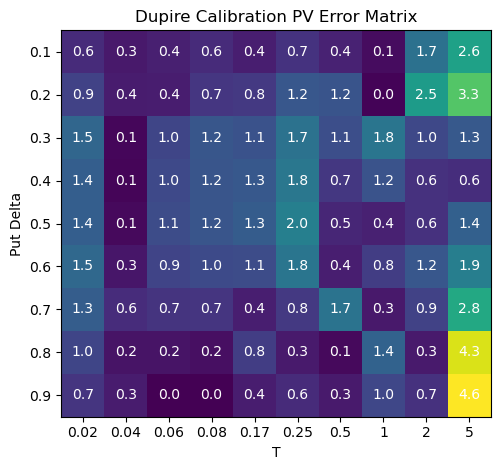

In [36]:
iv = createTestImpliedVol(S, 
                          r, 
                          q, 
                          sc = 0.0,         # No smile
                          smileInterpMethod='AF')

plotTestImpliedVolSurface(S, r, q, iv)

pdeCalibReport(S, r, q, iv)

We see that implied vol surface is not flat despite setting sc=0. Implied vol spikes at low T. 

---> As 1st step we will try to find optimal step K and step t in dVoldK, dVoldt and dVoldt2 in converting implied vol to local vol

In [38]:
class ImpliedVol_opt:
    def __init__(self, ts, smiles):
        
        '''
        ts: A list of times to expiry (tenors).
        smiles: A list of volatility smile objects, one for each expiry in ts.
        Each smiles[i] should have a method .Vol(k), which returns the implied volatility for a given strike k.
        '''
        self.ts = ts
        self.smiles = smiles

    
        
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # Determine where t falls within self.ts
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        
        #  If t is before the first expiry → use the first smile.
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        
        # If t is after the last expiry → use the last smile.
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        
        # If t is between two expiries, interpolate using variance-based linear interpolation
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT

In [39]:
class LocalVol_opt:
    def __init__(self, iv, S0, rd, rf, k_step, t_step):
        
        '''
        iv: An implied volatility surface (an instance of ImpliedVol).
        S0: The current spot price of the underlying asset.
        rd: The domestic interest rate (risk-free rate).
        rf: The foreign interest rate (used in FX options, otherwise set to 0).
        '''
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
        self.k_step = k_step
        self.t_step = t_step
        
    # This function transforms implied volatility into local volatility.
    # This is Lesson 5 Slide 19  
    def LV(self, t, s):
        # If t is extremely small (<1e−6), return the implied volatility as a fallback.
        if t < 1e-6:
            return self.iv.Vol(t, s)
        
        # Extract implied volatility and its derivatives
        imp = self.iv.Vol(t, s)
        dvdk = (self.iv.Vol(t, s + self.k_step) - self.iv.Vol(t, s - self.k_step)) / (2 * self.k_step) 
        dvdt = (self.iv.Vol(t + self.t_step, s) - self.iv.Vol(t, s)) / self.t_step
        d2vdk2 = (self.iv.Vol(t, s + self.k_step) + self.iv.Vol(t, s- self.k_step) - 2*self.iv.Vol(t, s)) / (self.k_step**2)
        
        # Compute d1 (Black-Scholes-like term)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        
        # Dupire's equation for local variance
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        
        # Ensure variance stays within reasonable bounds
        localvar = min(max(numerator / denominator, 1e-8), 1.0) # Safeguard procedure               # Check if these are ideal
        
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)

In [40]:
def createTestImpliedVol_opt(S, r, q, sc, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol_opt(pillars, smiles)

In [41]:
def optimize_dVoldK_dVoldT_dVol2dK2(S, r, q, sc, smileInterpMethod):
    k_step_sizes = [1e-6, 1e-5,1e-4, 1e-3]  
    t_step_size = [0.001, 0.0025,0.005]
    best_steps = {}
    min_error = float("inf")
    iv = createTestImpliedVol_opt(S, r, q, sc, smileInterpMethod)
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    print(iv)
    print(iv.Vol(tEnd, fwdEnd))
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call) 
    ks = np.arange(kmin, kmax, 0.01)
    for k_step in k_step_sizes:
        for t_step in t_step_size:
            vs = np.ndarray((len(ts), len(ks)))
            lv = LocalVol_opt(iv, S, r, q, k_step, t_step)
            lvs = np.ndarray((len(ts), len(ks)))
            
            total_error = 0
            for i in range(len(ts)):
                for j in range(len(ks)):
                    vs[i, j] = iv.Vol(ts[i], ks[j])
                    lvs[i, j] = lv.LV(ts[i], ks[j])
                    total_error += abs(vs[i,j] - lvs[i,j])
            print(k_step, t_step, total_error)
            if total_error < min_error:
                min_error = total_error
                best_steps = {"dVoldK": k_step, "dVoldT": t_step}
                    
    
    return best_steps, min_error

In [42]:
S, r, q, sc = 1.25805, 0.01, 0.0, 0.0
optimize_dVoldK_dVoldT_dVol2dK2(S, r, q, sc, smileInterpMethod ="AF")

     pcost       dcost       gap    pres   dres
 0:  5.6202e-02 -9.7036e+02  4e+03  2e+01  1e+02
 1:  5.7223e-02 -1.6525e+02  4e+02  2e+00  9e+00
 2:  6.2885e-02 -4.3236e+01  5e+01  2e-02  1e-01
 3:  6.2915e-02 -7.9988e-01  9e-01  3e-04  1e-03
 4:  6.1324e-02 -1.2645e-01  2e-01  6e-05  3e-04
 5:  5.9540e-02  1.6868e-02  4e-02  4e-06  2e-05
 6:  5.8482e-02  5.0017e-02  8e-03  6e-07  3e-06
 7:  5.7830e-02  5.6099e-02  2e-03  8e-08  4e-07
 8:  5.7555e-02  5.7164e-02  4e-04  1e-08  5e-08
 9:  5.7455e-02  5.7417e-02  4e-05  2e-10  1e-09
10:  5.7444e-02  5.7439e-02  5e-06  2e-11  1e-10
11:  5.7442e-02  5.7442e-02  3e-07  2e-13  8e-13
12:  5.7442e-02  5.7442e-02  2e-08  9e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6277e-02 -6.2499e+02  3e+03  2e+01  9e+01
 1:  5.7216e-02 -1.0776e+02  3e+02  1e+00  6e+00
 2:  6.0307e-02 -2.2455e+01  2e+01  1e-02  6e-02
 3:  6.0320e-02 -4.8212e-01  6e-01  3e-04  1e-03
 4:  5.9854e-02 -6.8720e-02  1e-01  5e-05  2e-0

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

Observation: It seems that the current step K and step t are optimal. No improvement made

### CONCLUSION

> The analysis of Dupire calibration errors offers meaningful insights into the strengths and limitations of local volatility models across different regions of moneyness and maturity. While these models demonstrate high accuracy for short-term and at-the-money (ATM) options, they struggle to capture the dynamics of long-dated or deep in-/out-of-the-money (ITM/OTM) options, particularly in regions with sparse market data. These limitations highlight the importance of model selection and regularization in volatility surface construction.
> 
> When comparing the pricing errors between the arbitrage-free smile interpolator and the standard cubic spline interpolator, it is evident that the arbitrage-free method yields significantly reduced errors. This improvement largely stems from the specific inequality constraints enforced during interpolation, which ensure arbitrage-free conditions are maintained throughout the surface.Specifically, the arbitrage-free approach applies a natural cubic spline to the call price function under well-defined linear inequality constraints. This method exhibits several advantageous properties: it guarantees a unique minimizer, achieves optimal convergence rates, and prevents interpolation anomalies between grid points. These characteristics contribute to a more stable and accurate volatility surface.
>
> In contrast, standard cubic spline interpolation, although smooth, often leads to larger calibration errors at the short end of the maturity spectrum. This occurs because if the raw market data admit arbitrage violations, the derived transition probabilities may become negative, thereby obstructing the convergence of finite difference schemes. Arbitrage-free models, by design, do not require arbitrage-free input data—thereby effectively mitigating mispricing and improving hedging performance under practical market conditions.
> To further enhance the realism of the implied volatility surface, one may employ local stochastic volatility models to fit the volatility smile, particularly at the extremes of the observed range. By assigning level, slope, and curvature factors, such models can better capture key surface features, including moneyness skew, term structure, and smile attenuation. Importantly, these factors should be constructed to ensure that the implied volatility surface remains twice continuously differentiable, which is crucial for generating a well-behaved risk-neutral density function for any given time horizon.
> 
> In conclusion, arbitrage-free models not only offer superior accuracy in local volatility estimation but also exhibit robust mathematical properties that support consistent derivative pricing and hedging. Continued research into hybrid and local stochastic volatility models, especially those that embed both flexibility and theoretical soundness, is essential for advancing financial modelling in increasingly complex markets.
